# 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
RANDOM_STATE = 2023

# 2. Dataset

## 2.1 Data Source and Description
Data source: [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

Context
Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk need early detection and management wherein a machine learning model can be of great help.

You will develop models to predict how likely a particular person is in developint cardiovascular disease, given all the information below.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

## 2.2 Loading the Dataset

In [2]:
df = pd.read_csv("heart.csv") # loading data using pandas

In [3]:
df.info() # viewing data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


This dataset is pretty clean already. There are not any missing values.

In [4]:
df.head().T # Retrieve the first five rows to examine detailed data.

,0,1,2,3,4
Age,40,49,37,48,54
Sex,M,F,M,F,M
ChestPainType,ATA,NAP,ATA,ASY,NAP
RestingBP,140,160,130,138,150
Cholesterol,289,180,283,214,195
FastingBS,0,0,0,0,0
RestingECG,Normal,Normal,ST,Normal,Normal
MaxHR,172,156,98,108,122
ExerciseAngina,N,N,N,Y,N
Oldpeak,0.0,1.0,0.0,1.5,0.0


In [5]:
def classes_num(df):
    """
    input is a DataFrame, and output is dictionary recording 
    how many unique values per feature of the DataFrame has
    """
    features_name = df.columns
    classes_per_feature = {}
    for f in features_name:
        classes_per_feature[f] = len(df[f].unique())
    return classes_per_feature

In [6]:
classes_num(df)

{'Age': 50,
 'Sex': 2,
 'ChestPainType': 4,
 'RestingBP': 67,
 'Cholesterol': 222,
 'FastingBS': 2,
 'RestingECG': 3,
 'MaxHR': 119,
 'ExerciseAngina': 2,
 'Oldpeak': 53,
 'ST_Slope': 3,
 'HeartDisease': 2}

The following six features 
- Sex
- ChestPainType
- FastingBS
- RestingECG
- ExerciseAngina
- ST_Slope

are **categorical**, and need to be one-hot encoded.

# 3. Data Analysis

In [7]:
# separate the heart disease cases and the normal cases
disease_df = df[df['HeartDisease']==1]
normal_df = df[df['HeartDisease']==0]

In [8]:
print(f'number of heart disease cases: {disease_df.shape[0]}\nnumber of normal cases: {normal_df.shape[0]}')

number of heart disease cases: 508
number of normal cases: 410


This binary classification is relatively balanced. 

In [9]:
# separate the male instances and female instances
male_index = df['Sex'] == 'M'
female_index = df['Sex'] == 'F'
male_df = df[male_index]
female_df = df[female_index]

In [10]:
print("male_samples:", male_df.shape[0])
print("female_samples:", female_df.shape[0])

male_samples: 725
female_samples: 193


The number of male samples is much greater than the number of female samples.

<Figure size 640x480 with 0 Axes>

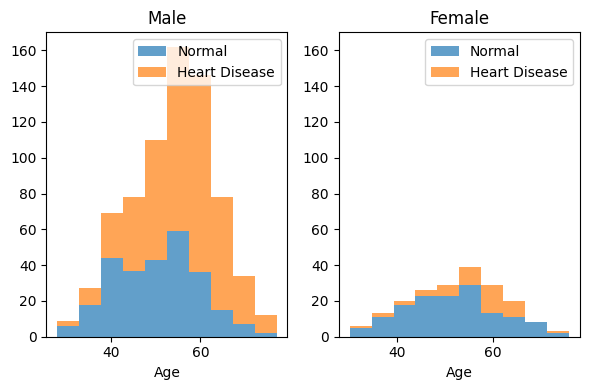

In [11]:
plt.subplots_adjust(hspace=0.5)
plt.figure(figsize = (6,4))
plt.subplot(1,2,1)
plt.hist([male_df[male_df['HeartDisease'] == 0]['Age'], male_df[male_df['HeartDisease'] == 1]['Age']],
         bins=10, alpha=0.7, label=['Normal', 'Heart Disease'], stacked=True)
plt.legend()
plt.xlabel('Age')
plt.title('Male')

plt.subplot(1,2,2, sharey=plt.gca())
plt.hist([female_df[female_df['HeartDisease'] == 0]['Age'], female_df[female_df['HeartDisease'] == 1]['Age']],
         bins=10, alpha=0.7, label=['Normal', 'Heart Disease'], stacked=True)
plt.legend()
plt.xlabel('Age')
plt.title('Female')
plt.tight_layout()
plt.show()

This graph clearly shows that the number of male samples is significantly higher than the number of female samples . Additionally, the likelihood of having CVDs among males is higher compared to females.

Text(0.5, 0, 'Chest Pain Type')

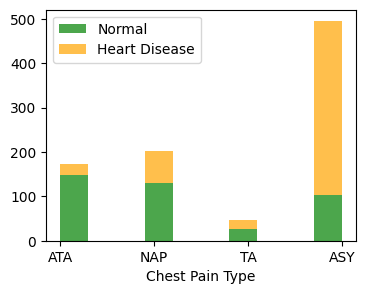

In [12]:
plt.figure(figsize=(4,3))
plt.hist([normal_df['ChestPainType'], disease_df['ChestPainType']], 
         label=['Normal', 'Heart Disease'], alpha=0.7, stacked=True, color = ['green','orange'])
plt.legend()
plt.xlabel('Chest Pain Type')

From the graph, it can be observed that the probability of having CVDs is highest in the asymptomatic group, implying that this type of heart disease is not easily detectable. This is an important reason for the high fatality rate associated with CV.

# 4. Data Engineering

**One-hot encoding categorical variables using Pandas**
First remove the binary variables, because one-hot encoding them would do nothing to them. 
- Sex
- FastingBS
- ExerciseAngina

are binary variables, and
- ChestPainType
- RestingECG
- ST_Slope

are multi variables.


In [13]:
df['Sex'] = df['Sex']=='M'
df['ExerciseAngina'] = df['ExerciseAngina'] == 'Y'

In [14]:
onehot_var = ['ChestPainType', 'RestingECG', 'ST_Slope']
# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.
df = pd.get_dummies(data = df,
                         prefix = onehot_var,
                         columns = onehot_var)

In [15]:
df.head().T # view the data after one-hot encoding

,0,1,2,3,4
Age,40,49,37,48,54
Sex,True,False,True,False,True
RestingBP,140,160,130,138,150
Cholesterol,289,180,283,214,195
FastingBS,0,0,0,0,0
MaxHR,172,156,98,108,122
ExerciseAngina,False,False,False,True,False
Oldpeak,0.0,1.0,0.0,1.5,0.0
HeartDisease,0,1,0,1,0
ChestPainType_ASY,False,False,False,True,False


# 5. Splitting the Dataset

In this section, split the dataset into train, validation and test datasets, using the function `train_test_split` from Scikit-learn.

**Seperate features and label**

In [16]:
features_list = list(df.columns)
features_list.remove('HeartDisease')

In [17]:
features_list

['Age',
 'Sex',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ChestPainType_TA',
 'RestingECG_LVH',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ST_Slope_Down',
 'ST_Slope_Flat',
 'ST_Slope_Up']

In [18]:
X, X_test, y, y_test = train_test_split(df[features_list], df['HeartDisease'], train_size = 0.8, random_state = RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, random_state = RANDOM_STATE)

In [19]:
# get the numbers of train samples, validation samples, and test samples.
print(f'train samples: {len(X_train)}\nvalidation samples: {len(X_valid)}\ntest samples: {len(X_test)}')

train samples: 587
validation samples: 147
test samples: 184


# 6. Building the Models

## 6.1 Decision Tree

Throw the training data into a basic decision tree model to inspect the performance of the tree model. Then use grid search method to fine tune hyperparameters. 

In [20]:
tree_trial = DecisionTreeClassifier()
tree_trial.fit(X_train, y_train)
train_pred = tree_trial.predict(X_train)
valid_pred = tree_trial.predict(X_valid)

In [21]:
acc_train_trail = accuracy_score(y_train, train_pred)
acc_valid_trial = accuracy_score(y_valid, valid_pred)
print(f'Accuracy of the train data is: {acc_train_trail}.\nAccuracy of the validation data is: {acc_valid_trial}.')

Accuracy of the train data is: 1.0.
Accuracy of the validation data is: 0.8163265306122449.


The model achieved perfect results on the training set, indicating complete **overfitting**. It is necessary to control the hyperparameters of the decision tree model to mitigate overfitting issues. Here, grid search is employed to find the optimal hyperparameters for min_samples_split and max_depth.

In [22]:
# fine tuning the tree model
param_grid = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split': [10, 20, 30, 40, 50]}
tree_gs = DecisionTreeClassifier(random_state = RANDOM_STATE)
grid_search = GridSearchCV(tree_gs, param_grid, cv=5, scoring='accuracy', return_train_score = True)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2023),
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_split': [10, 20, 30, 40, 50]},
             return_train_score=True, scoring='accuracy')

In [23]:
grid_search.best_params_

{'max_depth': 3, 'min_samples_split': 10}

In [24]:
final_tree = grid_search.best_estimator_

In [25]:
final_tree.fit(X, y)
train_final_tree_pred = final_tree.predict(X)
test_final_tree_pred = final_tree.predict(X_test)
acc_train_final_tree = accuracy_score(y, train_final_tree_pred)
acc_test_final_tree = accuracy_score(y_test, test_final_tree_pred)
print(f'Accuracy of the train data is: {acc_train_final_tree}.\nAccuracy of the test data is: {acc_test_final_tree}.')

Accuracy of the train data is: 0.8596730245231607.
Accuracy of the test data is: 0.8369565217391305.


The optimal hyperparameters found by the grid search are max_depth=3 and min_samples_split=10. The complete training set was used to train the optimized decision tree model, resulting in prediction accuracies of $0.86$ for the training set and $0.84$ for the test set. The variance of the model has decreased significantly. Next, try ensemble learning methods to enhance the performance of the estimator.

## 6.2 Random Forest

Adopt grid search to fine tune the hyperparameters for min_samples_split, max_depth and n_estimators in a random forest model.

In [26]:
# fine tuning the random forest model
param_grid_forest = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split': [10, 20, 30, 40, 50], 'n_estimators': [10, 50, 100, 200, 500]}
forest_gs = RandomForestClassifier(random_state = RANDOM_STATE)
grid_search_forest = GridSearchCV(forest_gs, param_grid_forest, cv=5, scoring='accuracy', return_train_score = True)
grid_search_forest.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2023),
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_split': [10, 20, 30, 40, 50],
                         'n_estimators': [10, 50, 100, 200, 500]},
             return_train_score=True, scoring='accuracy')

In [27]:
grid_search_forest.best_params_

{'max_depth': 9, 'min_samples_split': 30, 'n_estimators': 50}

In [28]:
final_forest = grid_search_forest.best_estimator_

In [29]:
train_final_forest_pred = final_forest.predict(X)
test_final_forest_pred = final_forest.predict(X_test)
acc_train_final_forest = accuracy_score(y, train_final_forest_pred)
acc_test_final_forest = accuracy_score(y_test, test_final_forest_pred)
print(f'Accuracy of the train data is: {acc_train_final_forest}.\nAccuracy of the test data is: {acc_test_final_forest}.')

Accuracy of the train data is: 0.8896457765667575.
Accuracy of the test data is: 0.8967391304347826.


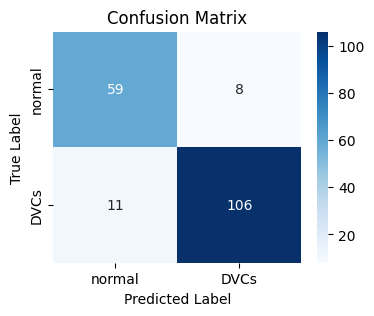

In [30]:
# inspect the confusion matrix
cm = confusion_matrix( y_test, test_final_forest_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['normal','DVCs'], yticklabels=['normal','DVCs'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

The optimal hyperparameters found by the grid search are max_depth=9, min_samples_split=30, and n_estimators=50. The complete training set was used to train the optimized random forest model, resulting in prediction accuracies of $0.88$ for the training set and $0.89$ for the test set. The performance of the estimator has been improved obviously. 

Inspect the relative importance of each feature for making accurate predictions.

In [31]:
attributes = list(X.columns)
feature_importances = final_forest.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.2423352417221146, 'ST_Slope_Up'),
 (0.1454963481123454, 'ST_Slope_Flat'),
 (0.11803811856560646, 'ChestPainType_ASY'),
 (0.10355804217436622, 'ExerciseAngina'),
 (0.07959797121495779, 'Oldpeak'),
 (0.06524525567445173, 'Cholesterol'),
 (0.05994688851530748, 'MaxHR'),
 (0.046662048575278586, 'Sex'),
 (0.03340069281856819, 'Age'),
 (0.025349804026919602, 'RestingBP'),
 (0.024121241846083066, 'ChestPainType_ATA'),
 (0.022905305042007353, 'FastingBS'),
 (0.01125146826767797, 'ST_Slope_Down'),
 (0.009289325451059649, 'ChestPainType_NAP'),
 (0.005019278063280228, 'ChestPainType_TA'),
 (0.0026775291782858875, 'RestingECG_ST'),
 (0.00255799597055193, 'RestingECG_LVH'),
 (0.002547444781137853, 'RestingECG_Normal')]

With this information, it might be better to drop the RestingECG feature since it is much less useful, and then retrain the random forest model.

In [32]:
# drop the unimportant feature from the original dataframe
df_reduced = df[features_list].drop(columns=['RestingECG_ST','RestingECG_LVH','RestingECG_Normal'])
# split the data set into traning and testing again
X_re, X_test_re, y_re, y_test_re = train_test_split(df_reduced, df['HeartDisease'], train_size = 0.8, random_state = RANDOM_STATE)

In [33]:
# retrain the random forest model after dropping the less important features
param_grid_forest = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split': [10, 20, 30, 40, 50], 'n_estimators': [10, 50, 100, 200, 500]}
forest_gs = RandomForestClassifier(random_state = RANDOM_STATE)
grid_search_forest = GridSearchCV(forest_gs, param_grid_forest, cv=5, scoring='accuracy', return_train_score = True)
grid_search_forest.fit(X_re, y_re)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2023),
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_split': [10, 20, 30, 40, 50],
                         'n_estimators': [10, 50, 100, 200, 500]},
             return_train_score=True, scoring='accuracy')

In [34]:
grid_search_forest.best_params_

{'max_depth': 11, 'min_samples_split': 10, 'n_estimators': 100}

In [35]:
optimal_forest = grid_search_forest.best_estimator_

In [36]:
train_forest_pred = optimal_forest.predict(X_re)
test_forest_pred = optimal_forest.predict(X_test_re)
acc_train_forest = accuracy_score(y_re, train_forest_pred)
acc_test_forest = accuracy_score(y_test_re, test_forest_pred)
print(f'Accuracy of the train data is: {acc_train_forest}.\nAccuracy of the test data is: {acc_test_forest}.')

Accuracy of the train data is: 0.9386920980926431.
Accuracy of the test data is: 0.9021739130434783.


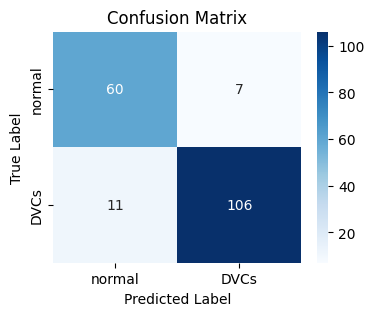

In [41]:
# inspect the confusion matrix
cm_new = confusion_matrix( y_test_re, test_forest_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm_new, annot=True, fmt='g', cmap='Blues', xticklabels=['normal','DVCs'], yticklabels=['normal','DVCs'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

After removing features with low correlation, the model's predictive accuracy has slightly improved.

## 6.3 XGBoost

In [37]:
# try another ensembel algorithm belonging to boosting named XGBoost
# 
X_train_re, X_valid_re, y_train_re, y_valid_re = train_test_split(X_re, y_re, train_size = 0.8, random_state = RANDOM_STATE)
xgboost = XGBClassifier(n_estimators = 100, verbosity = 1, early_stopping_rounds = 10, random_state = RANDOM_STATE)
xgboost.fit(X_train_re,y_train_re, eval_set = [(X_valid_re,y_valid_re)])

[0]	validation_0-logloss:0.54607
[1]	validation_0-logloss:0.47063
[2]	validation_0-logloss:0.43320
[3]	validation_0-logloss:0.40685
[4]	validation_0-logloss:0.38774
[5]	validation_0-logloss:0.37271
[6]	validation_0-logloss:0.36697
[7]	validation_0-logloss:0.36421
[8]	validation_0-logloss:0.35255
[9]	validation_0-logloss:0.34882
[10]	validation_0-logloss:0.35390
[11]	validation_0-logloss:0.36164
[12]	validation_0-logloss:0.36540
[13]	validation_0-logloss:0.36631
[14]	validation_0-logloss:0.36940
[15]	validation_0-logloss:0.37224
[16]	validation_0-logloss:0.37249
[17]	validation_0-logloss:0.37290
[18]	validation_0-logloss:0.37877
[19]	validation_0-logloss:0.38036


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=2023, ...)

In [38]:
xgboost.best_iteration

9

In [39]:
train_xgboost_pred = xgboost.predict(X_re)
test_xgboost_pred = xgboost.predict(X_test_re)
acc_train_xgboost = accuracy_score(y, train_xgboost_pred)
acc_test_xgboost = accuracy_score(y_test, test_xgboost_pred)
print(f'Accuracy of the train data is: {acc_train_xgboost}.\nAccuracy of the test data is: {acc_test_xgboost}.')

Accuracy of the train data is: 0.9373297002724795.
Accuracy of the test data is: 0.8152173913043478.


The XGBoost model performs less effectively than the Random Forest model, but trains much faster than the Random Forest model.

# 7. Conclusion

In this work, I employed three different tree models. The first one is a standalone decision tree model, and the other two are ensemble models based on decision trees—specifically, a random forest model belonging to bagging algorithm and an XGBoost model belonging to boosting algorithm. Among the three models, the random forest exhibited the best predictive performance, achieving an accuracy of over 90% on the test set.